## Load and Create Dataset

In [ ]:
pip install google-cloud-bigquery

In [5]:
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [6]:


# Setup Google Cloud BigQuery API

# Replace with your own key path
key_path = "/Users/theodoreleeiv/Documents/Documents - Theodore’s MacBook Pro/Google Cloud/inbound-density-428819-p8-aef577a5f38e.json"
credentials = service_account.Credentials.from_service_account_file(key_path)

client = bigquery.Client()


def QUERY(query):
    """
    Queries BigQuery
    :param query: string
    :return: dataframe
    """
    query = str(query)
    query_job = client.query(query)
    return query_job.result().to_dataframe()

In [7]:

df = QUERY("""
  SELECT
    r.subject_id,
    r.stay_id,
    r.hadm_id,
    r.readmit_stay_id,
    edadmitdate,
    eddischargedate,
    EXTRACT(DAYOFWEEK FROM eddischargedate) AS discharge_dow,
    EXTRACT(MONTH FROM eddischargedate) AS discharge_month,
    edadmithour,
    eddischargehour,
    LOS_hr,
    arrival_transport,
    disposition,
    gender,
    anchor_age,
    insurance,
    marital_status,
    language,
    race_group,
    temperature,
    heartrate,
    resprate,
    o2sat,
    sbp,
    dbp,
    acuity,
    m.name AS med_name,
    icd_title,
    mental_health_category,
    is_readmission
  

FROM
  `inbound-density-428819-p8.patient_info.MH-ED-READMISSIONS` AS r

LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-PATIENT-DEMO` AS p

ON r.subject_id = p.subject_id

LEFT JOIN
  `inbound-density-428819-p8.patient_info.MH-ED-DIAGNOSIS` AS d
ON
  r.stay_id = d.stay_id
  
LEFT JOIN
    `physionet-data.mimiciv_ed.triage` AS t
ON 
    r.stay_id = t.stay_id
LEFT JOIN 
    `physionet-data.mimiciv_ed.medrecon` AS m
ON  
    r.stay_id = m.stay_id
  
WHERE d.is_mh_disorder = 1
""")

In [8]:
# Calculate the number of comorbities per patient per visit

comorbities = QUERY("""
  SELECT
    subject_id,
    stay_id,
    SUM(num_comorbities) AS num_comorbitites
    FROM
    (SELECT
      d.subject_id,
      d.stay_id,
      CASE
        WHEN seq_num > 1 THEN 1
        ELSE 0
      END AS num_comorbities
    FROM
      `inbound-density-428819-p8.patient_info.MH-ED-DIAGNOSIS` AS d

    WHERE d.is_mh_disorder = 1
    ORDER BY
      num_comorbities DESC) AS patient_counts
GROUP BY
  subject_id,stay_id

""")

In [9]:
# merge the number of comorbitites with the main dataframe on subject_id and stay_id
df = df.merge(comorbities,how='left',on=['subject_id','stay_id'])

### Drop Duplicates

In [10]:
# Drop any duplicates if there are any in the data
df.drop_duplicates(inplace=True)

### Split the Data into training and test sets

In [11]:
from sklearn.model_selection import train_test_split
train_df,test_df = train_test_split(df,test_size=0.25,random_state=42)

In [12]:
train_df.head()

,subject_id,stay_id,hadm_id,readmit_stay_id,edadmitdate,eddischargedate,discharge_dow,discharge_month,edadmithour,eddischargehour,...,resprate,o2sat,sbp,dbp,acuity,med_name,icd_title,mental_health_category,is_readmission,num_comorbitites
427553,17916702,35064369,25083063,<NA>,2151-07-30,2151-07-31,7,7,2,14,...,16.000000000,97.000000000,135.000000000,71.000000000,3.000000000,acamprosate,"Alcohol abuse with intoxication, unspecified",Substance-Related Mental Disorders,0,2
365167,17290849,39883215,24964358,39883215,2161-08-19,2161-08-20,5,8,15,0,...,18.000000000,98.000000000,125.000000000,75.000000000,2.000000000,zolpidem,ANXIETY STATE NOS,Anxiety and Related Disorders,1,0
326997,12104721,38538381,22525788,38538381,2133-08-21,2133-08-21,6,8,8,14,...,16.000000000,98.000000000,124.000000000,83.000000000,2.000000000,trazodone,DEPRESSIVE DISORDER,Mood Disorders,1,1
285974,15107347,38217753,22694639,<NA>,2157-03-31,2157-03-31,5,3,15,21,...,18.000000000,100.000000000,119.000000000,78.000000000,3.000000000,venlafaxine,DEPRESSIVE DISORDER,Mood Disorders,0,1
54922,17455650,32121672,28442411,<NA>,2130-06-05,2130-06-06,3,6,13,7,...,16.000000000,99.000000000,112.000000000,73.000000000,2.000000000,diazepam,DEPRESSIVE DISORDER,Mood Disorders,0,0


In [13]:
train_df.shape

(205143, 31)

### Check for NaNs

In [14]:
train_df.isnull().sum()

subject_id                     0
stay_id                        0
hadm_id                    63726
readmit_stay_id           142212
edadmitdate                    0
eddischargedate                0
discharge_dow                  0
discharge_month                0
edadmithour                    0
eddischargehour                0
LOS_hr                         0
arrival_transport              0
disposition                    0
gender                         0
anchor_age                    10
insurance                  21733
marital_status             12792
language                   10315
race_group                     0
temperature                 7715
heartrate                   4947
resprate                    6946
o2sat                       6441
sbp                         5286
dbp                         5880
acuity                      1109
med_name                   23316
icd_title                      0
mental_health_category         0
is_readmission                 0
num_comorb

There is quite of bit of NaNs in the data. However, some NaNs are expected in hadm_id, not all patients have an associated hadm_id or readmit_stay_id, days_to_readmission, med_name (medication name).

In [15]:
train_df.isnull().sum()

subject_id                     0
stay_id                        0
hadm_id                    63726
readmit_stay_id           142212
edadmitdate                    0
eddischargedate                0
discharge_dow                  0
discharge_month                0
edadmithour                    0
eddischargehour                0
LOS_hr                         0
arrival_transport              0
disposition                    0
gender                         0
anchor_age                    10
insurance                  21733
marital_status             12792
language                   10315
race_group                     0
temperature                 7715
heartrate                   4947
resprate                    6946
o2sat                       6441
sbp                         5286
dbp                         5880
acuity                      1109
med_name                   23316
icd_title                      0
mental_health_category         0
is_readmission                 0
num_comorb

### Clean and Transform Columns

In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 205143 entries, 427553 to 194973
Data columns (total 31 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   subject_id              205143 non-null  Int64 
 1   stay_id                 205143 non-null  Int64 
 2   hadm_id                 141417 non-null  Int64 
 3   readmit_stay_id         62931 non-null   Int64 
 4   edadmitdate             205143 non-null  dbdate
 5   eddischargedate         205143 non-null  dbdate
 6   discharge_dow           205143 non-null  Int64 
 7   discharge_month         205143 non-null  Int64 
 8   edadmithour             205143 non-null  Int64 
 9   eddischargehour         205143 non-null  Int64 
 10  LOS_hr                  205143 non-null  Int64 
 11  arrival_transport       205143 non-null  object
 12  disposition             205143 non-null  object
 13  gender                  205143 non-null  object
 14  anchor_age              205133 non-n

In [17]:
# set the index to stay_id
train_df.set_index('stay_id',inplace=True)


Cleaning/Transformation Tasks
- Convert gender column to numeric binary
- Change the dtype of temperature, heartrate, reprate,o2sat, sbp, dbp, pain, and acuity to float values
- Unmarried individuals, feature engineer a binary variable, married vs unmarried
- Black/African Patiants, feature engineer a binary variable, Black/African?
- PORTUGUESE Patiants, feature engineer a binary variable, PORTUGUESE?
- Cuban Patiants, feature engineer a binary variable, Cuban?
- BLACK/AFRICAN AMERICAN patiants, feature engineer a binary variable, BLACK/AFRICAN AMERICAN?
- Puerto Rican Patiants, feature engineer a binary variable, Puerto Rican?
- Unknown Patiants, feature engineer a binary variable, Unknown?
- Hispanic or Latino Patiants, feature engineer a binary variable, Hispanic or Latino?
- Honduran Patiants, feature engineer a binary variable, Honduran?
- Patients 50 - 59
- Patients 40 - 49
- Num of Comorbitites
- Various medications (Create medication frequiences accounting for medications not listed by setting the default to 0) -> compute frequencies on the training set to prevent data leakage

In [18]:
# Create a customtransofrmer for each column transformation for the pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Change gender column to a binary

class GenderMapper(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.gender_map = {'F': 0, 'M': 1}  

    def fit(self, X, y=None):
        return self  

    def transform(self, X):
        X_copy = X.copy()
        # Apply the gender mapping to the gender column
        if 'gender' in X_copy.columns:
            X_copy['gender'] = X_copy['gender'].map(self.gender_map)
        return X_copy

In [19]:
# change the dtype of temperature, heartrate, reprate,o2sat, sbp, dbp, and acuity to float values
class ConvertVitalSignsToFloats(BaseEstimator, TransformerMixin):
    """
    Converts Vital Signs to Floats
    """
    def __init__(self):
        self.type = float
    def fit(self, X, y=None):
        return self  
    def transform(self, X):
        X_copy = X.copy()
        
        vital_cols = ['temperature','heartrate','resprate','o2sat','sbp','dbp','acuity']
        
        for col in vital_cols:
            if col in X_copy.columns:
                try:
                    X_copy[col] =  X_copy[col].astype(float)
                except ValueError as e:
                    print(f"[Error] Could not convert column '{col}' to float. Error: {e} converting to NaN")
                    X_copy[col] = pd.to_numeric(X_copy[col], errors='coerce')
                    
            else:
                print(f'Not Column {col} not found in list')
        return X_copy
    
class CelsiusToFahrenheit(BaseEstimator, TransformerMixin):
    """
    Converts temperature signs recorded in celsisus to fahrenheit
    """
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self  
    def transform(self, X):
        X_copy = X.copy()
        
        if 'temperature' in X_copy.columns:
            try:
                 # Create a mask for likely Celsius values
                mask = X_copy['temperature'] <= 38
                X_copy.loc[mask, 'temperature'] = X_copy.loc[mask, 'temperature'] * 9/5 + 32
            except ValueError as e:
                print(f"[Error] Could not convert column. Error: {e}")
        return X_copy
    

In [20]:
# Create an unmarried vs married column from marital status column
class MaritalStatusMapper(BaseEstimator, TransformerMixin):
    """
    Converts marital status to a binary variable, married/partnered vs single/ not partnered
    """
    def __init__(self):
        self.is_married_map = {'None':1,'MARRIED':1,'WIDOWED':0,'DIVORCED':0,'SINGLE':0}

    def fit(self, X, y=None):
        return self  

    def transform(self, X):
        X_copy = X.copy()
        # Apply the gender mapping to the gender column
        if 'marital_status' in X_copy.columns:
            X_copy['marital_status'] = X_copy['marital_status'].map(self.is_married_map)
        return X_copy


In [21]:
class GetTotalAdmissionsAndDischarges(BaseEstimator, TransformerMixin):
    """
    Calculates total admissions and discharges per admission day and discharge day, respectively
    """
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self  

    def transform(self, X):
        X_copy = X.copy().reset_index()
        
        # calculate the total admissions and total discharges 
        total_admissions = X_copy.groupby(by='edadmitdate')['stay_id'].count().reset_index().rename(columns={'stay_id':'total_admissions'})
        total_discharges = X_copy.groupby(by='eddischargedate')['stay_id'].count().reset_index().rename(columns={'stay_id':'total_discharges'})
        
        # merge these with original dataframe
        X_copy = X_copy.merge(total_admissions,how='left',on=['edadmitdate'])
        X_copy = X_copy.merge(total_discharges,how='left',on=['eddischargedate'])
        X_copy.drop(['edadmitdate','eddischargedate'],axis=1,inplace=True)
        X_copy.set_index('stay_id', inplace=True)
        return X_copy


In [22]:
from collections import defaultdict

class GetMedicationFrequencies(BaseEstimator, TransformerMixin):
    """
    Encode medications using their frequency
    """
    def __init__(self):
        self.med_to_freq = None
        self.freq_to_meds = None

    def fit(self, X, y=None):
        # Learn med freqencies
        freqs =  X['med_name'].value_counts().to_dict()
        
        # Mapping: med_names → frequency
        self.med_to_freq = defaultdict(lambda: 0, freqs)
        
        # Mapping: frequency → set of med_names
        self.freq_to_meds = defaultdict(set)
        for med, freq in freqs.items():
            self.freq_to_meds[freq].add(med)

        return self  

    def transform(self, X):
        X_copy = X.copy()
        # Replace meds with their frequency
        X_copy['med_name'] =  X_copy['med_name'].map(self.med_to_freq)
        
        # Rename the med column name
        X_copy.rename(columns={'med_name':'med_freq_id'},inplace=True)
        
        # Create a dataframe of the sum of frequencies per visit

        med_freq_id = X_copy.groupby(['stay_id'])['med_freq_id'].sum().reset_index()
        med_freq_id.rename(columns={'med_freq_id':'sum_of_med_freq_id'},inplace=True)
        
        # Drop the old med freq id
        X_copy.drop(columns=['med_freq_id'],axis=1,inplace=True)
        
        # merge the sum of frequiences per visit back to original dataframes
        X_copy = X_copy.merge(med_freq_id,how='left',on=['stay_id'])
        X_copy.set_index('stay_id', inplace=True)
        
        return X_copy
    



In [23]:
class GetLanguageFrequencies(BaseEstimator, TransformerMixin):
    """
    Encode medications using their frequency
    """
    def __init__(self):
        self.language_to_freq = None
        self.freq_to_language = None

    def fit(self, X, y=None):
        # Learn med freqencies
        freqs =  X['language'].value_counts().to_dict()
        
        # Mapping: languages → frequency
        self.language_to_freq = defaultdict(lambda: 0, freqs)
        
        # Mapping: frequency → set of languages
        self.freq_to_language = defaultdict(set)
        for language, freq in freqs.items():
            self.freq_to_language[freq].add(language)

        return self  

    def transform(self, X):
        X_copy = X.copy()
        # Replace meds with their frequency
        X_copy['language'] =  X_copy['language'].map(self.language_to_freq)
        
        # Rename the med column name
        X_copy.rename(columns={'language':'language_freq_id'},inplace=True)
        
        # Create a dataframe of the sum of frequencies per visit

        language_freq_id = X_copy.groupby(['stay_id'])['language_freq_id'].sum().reset_index()
        language_freq_id.rename(columns={'language_freq_id':'sum_of_language_freq_id'},inplace=True)
        
        # Drop the old language freq id
        X_copy.drop(columns=['language_freq_id'],axis=1,inplace=True)
    
        
        # merge the sum of frequiences per visit back to original dataframes
        X_copy = X_copy.merge(language_freq_id,how='left',on=['stay_id'])
        X_copy.set_index('stay_id', inplace=True)
        
        return X_copy

In [24]:
class GetDisposition(BaseEstimator, TransformerMixin):
    """
    Creates a binary variable to indiciate whether a patient LWBS or was treated prior to leaving the facility
    """
    def __init__(self):
        self.dispositions = ['ELOPED','LEFT AGAINST MEDICAL ADVICE','LEFT WITHOUT BEING SEEN']

    def fit(self, X, y=None):
        return self  

    def transform(self, X):
        X_copy = X.copy()
        # 1 if the patient left without getting proper treatment else 0
        X_copy['disposition'] = X_copy['disposition'].apply(lambda x: 1 if x in self.dispositions else 0 )
        return X_copy

In [25]:
class GetDiagnosesFrequencies(BaseEstimator, TransformerMixin):
    """
    Encode Patient Diagnoses and creates a summed value
    """
    def __init__(self):
        self.diagnosis_to_freq = None
        self.freq_to_diangosis = None

    def fit(self, X, y=None):
        # Learn med freqencies
        freqs =  X['icd_title'].value_counts().to_dict()
        
        # Mapping: diagnosis_names → frequency
        self.diagnosis_to_freq = defaultdict(lambda: 0, freqs)
        
        # Mapping: frequency → set of diagnosis_names
        self.freq_to_diangosis = defaultdict(set)
        for diagnosis, freq in freqs.items():
            self.freq_to_diangosis[freq].add(diagnosis)

        return self  

    def transform(self, X):
        X_copy = X.copy()
        # Replace meds with their frequency
        X_copy['icd_title'] =  X_copy['icd_title'].map(self.diagnosis_to_freq)
        
        # Rename the icd title column name
        X_copy.rename(columns={'icd_title':'icd_freq_id'},inplace=True)
        
        # Create a dataframe of the sum of frequencies per visit
        icd_freq_id = X_copy.groupby(['stay_id'])['icd_freq_id'].sum().reset_index()
        icd_freq_id.rename(columns={'icd_freq_id':'sum_of_icd_freq_id'},inplace=True)
        
        # Drop the old diangoses freq id
        X_copy.drop(columns=['icd_freq_id'],inplace=True)
        
        
        # merge the sum of frequiences per visit back to original dataframes
        X_copy = X_copy.merge(icd_freq_id,how='left',on=['stay_id'])
        X_copy.set_index('stay_id', inplace=True)
        
        return X_copy

In [26]:
class InsuranceMapper(BaseEstimator, TransformerMixin):
    """
    Create a binary variable for low readmission based on insurance type
    """
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self  

    def transform(self, X):
        X_copy = X.copy()
        X_copy['low_readmit_insurance'] = X_copy['insurance'].apply(lambda x: 1 if x in ['Private', 'None'] else 0)
        
        return X_copy

In [27]:
class NumericImputer(BaseEstimator, TransformerMixin):
    """
    Only imputes numeric columns
    """
    def __init__(self, strategy='mean'):
        self.strategy = strategy
        self.imputer = SimpleImputer(strategy=self.strategy)
        self.numeric_cols = []

    def fit(self, X, y=None):
        self.numeric_cols = X.select_dtypes(include='number').columns
        self.imputer.fit(X[self.numeric_cols])
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.numeric_cols] = self.imputer.transform(X_copy[self.numeric_cols])
        return X_copy

In [64]:
class StandardScalar_Custom(BaseEstimator, TransformerMixin):
    """
    Only scale numeric columns
    """
    def __init__(self):
        self.scaler = StandardScaler()
        self.numeric_cols = []

    def fit(self, X, y=None):
        self.numeric_cols = X.select_dtypes(include='number').columns
        self.scaler.fit(X[self.numeric_cols])
        return self

    def transform(self, X):
        X_copy = X.copy()
        
        X_copy[self.numeric_cols] = self.scaler.transform(X_copy[self.numeric_cols])
        return X_copy
    
    def inverse_transform(self, X):
        X_copy = X.copy()
        X_copy[self.numeric_cols] = self.scaler.inverse_transform(X_copy[self.numeric_cols])
        return X_copy

In [29]:
class CreateDummies(BaseEstimator, TransformerMixin):
    """
    Convert categorical 'object' columns into dummy variables.
    """
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        self.dummy_columns = X.select_dtypes(include=['object']).columns.tolist()  # Identify categorical columns
        return self  # Return self for pipeline compatibility

    def transform(self, X):
        X_copy = X.copy()  # Copy input DataFrame to avoid changing original
        # Create dummy variables for categorical columns, drop first category to avoid multicollinearity
        X_copy = pd.get_dummies(X_copy, columns=self.dummy_columns, dtype='Int64', drop_first=True)
        return X_copy  # Return transformed DataFrame

### Create Preprocessing Pipeline

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Build Preprocessing Pipeline for later preprocessing of new data
X_train_preprocessing_Pipeline = Pipeline(
    [
        ('ConvertVitalSigns',ConvertVitalSignsToFloats()), # Converts vital signs to floats
        ('CelsiusToFahrenheit',CelsiusToFahrenheit()), # Standardizes temperature, converting it to Fahrenheit
        ('GetMedicationFrequencies',GetMedicationFrequencies()),# Converts medications into frequencies
        ('GetDiagnosesFrequencies',GetDiagnosesFrequencies()), # Converts Diagnosis to frequencies
        ('GetLanguageFrequencies',GetLanguageFrequencies()), # Converts languages to frequencies
        ('GetTotalAdmissionsAndDischarges',GetTotalAdmissionsAndDischarges()), # Calcaultes the total number of admissions and discharges for a given day
        ('Scaler', StandardScalar_Custom()), # Scales data
        ('MapGender',GenderMapper()), # Maps gender to 1 or 0, 1: male, 0: female
        ('MaritalStatusMapper',MaritalStatusMapper()), # Maps maritalstats to 1 or 0, 1: ismarried, 0: not married
        ('GetDisposition',GetDisposition()), # Maps disposition to 1 or 0. 1: LWBS, 0: Got treatment
        ('MapInsurance',InsuranceMapper()),# Maps insurance to 1 or 0. 1: low readmission, 0: high readmission
        ('OnehotEncoder',CreateDummies()),
        ('SimpleImputer', NumericImputer(strategy='mean')),  # Fill the nulls with the mean value for applicable features
    ]
)

train_df_cleaned = X_train_preprocessing_Pipeline.fit_transform(train_df.drop(['is_readmission'],axis=1))



In [31]:
train_df_cleaned = train_df_cleaned.merge(train_df[['is_readmission']],left_index=True,right_index=True,how='left')
train_df_cleaned.drop_duplicates(inplace=True)

In [32]:
print('train shape:',train_df_cleaned.shape)

train shape: (51533, 59)


In [33]:
train_df_cleaned.columns

Index(['subject_id', 'hadm_id', 'readmit_stay_id', 'discharge_dow',
       'discharge_month', 'edadmithour', 'eddischargehour', 'LOS_hr', 'gender',
       'anchor_age', 'marital_status', 'temperature', 'heartrate', 'resprate',
       'o2sat', 'sbp', 'dbp', 'acuity', 'num_comorbitites',
       'sum_of_med_freq_id', 'sum_of_icd_freq_id', 'sum_of_language_freq_id',
       'total_admissions', 'total_discharges', 'low_readmit_insurance',
       'arrival_transport_HELICOPTER', 'arrival_transport_OTHER',
       'arrival_transport_UNKNOWN', 'arrival_transport_WALK IN',
       'disposition_ELOPED', 'disposition_EXPIRED', 'disposition_HOME',
       'disposition_LEFT AGAINST MEDICAL ADVICE',
       'disposition_LEFT WITHOUT BEING SEEN', 'disposition_OTHER',
       'disposition_TRANSFER', 'insurance_Medicare', 'insurance_No charge',
       'insurance_Other', 'insurance_Private', 'race_group_Asian',
       'race_group_Black / African American', 'race_group_Hispanic / Latino',
       'race_group_Mul

### Describe the Data

In [34]:
train_df_cleaned.describe()

,subject_id,hadm_id,readmit_stay_id,discharge_dow,discharge_month,edadmithour,eddischargehour,LOS_hr,gender,anchor_age,...,mental_health_category_Childhood and Adolescent Disorders,mental_health_category_Developmental Disorders,mental_health_category_Intellectual Disabilities,mental_health_category_Mood Disorders,mental_health_category_Organic Mental Health Disorders,mental_health_category_Personality and Behavioral Disorders,mental_health_category_Psychotic Disorders,mental_health_category_Substance-Related Mental Disorders,mental_health_category_Unspecified Mental Disorders,is_readmission
count,51533.000000,5.153300e+04,5.153300e+04,51533.000000,51533.000000,51533.000000,51533.000000,51533.000000,51533.000000,51533.000000,...,51533.000000,51533.000000,51533.000000,51533.000000,51533.000000,51533.000000,51533.000000,51533.000000,51533.000000,51533.0
mean,0.032896,5.107455e-03,-9.651232e-03,0.007180,-0.004468,-0.034547,-0.129857,-0.050903,0.618283,-0.319343,...,0.005433,0.002018,0.004483,0.258766,0.055072,0.006578,0.079270,0.482545,0.000078,0.28636
std,1.015442,8.079655e-01,5.343241e-01,0.997917,0.998225,1.112711,0.993632,0.932099,0.485812,0.950851,...,0.073512,0.044879,0.066802,0.437961,0.228122,0.080840,0.270162,0.499700,0.008810,0.452064
min,-1.813980,-1.727483e+00,-1.775177e+00,-1.480881,-1.621630,-2.207692,-2.041713,-0.932373,0.000000,-1.681195,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,-0.814281,-4.027767e-01,-1.763909e-16,-0.984806,-0.756163,-0.732410,-0.979465,-0.570118,0.000000,-1.121124,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
50%,0.081729,-8.792789e-18,-1.763909e-16,0.007344,0.109303,0.087191,-0.068966,-0.352766,1.000000,-0.337026,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
75%,0.884490,4.250485e-01,-1.763909e-16,0.999494,0.974770,0.906792,0.689783,0.154391,1.000000,0.279052,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.0
max,1.839471,1.738204e+00,1.684954e+00,1.495569,1.551747,1.562473,1.448532,13.050653,1.000000,2.407320,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0


In [35]:
train_df_cleaned['gender'].unique()


array([1., 0.])

### Identify Multicolinearited Features

In [36]:
# Variables that are linearly correlated with each other may be communicating the same information. So, I can just identify them in advance and remove them from the analysis or I can combine them into one variable all together.
from statsmodels.stats.outliers_influence import variance_inflation_factor
# VIF is a statistical method used to detect and quantify multicollinearity in regression models. It helps identify how much the variance of a regression coefficient is inflated due to the correlation between predictor variables.

features = train_df_cleaned.select_dtypes(include='float').drop(columns=['subject_id','hadm_id','readmit_stay_id'])
X = features.values

# VIF DataFrame
vif_df = pd.DataFrame()
# calculating VIF for each feature
vif_df['feature'] = features.columns
vif_df.set_index('feature', inplace=True)
vif_df["VIF"] = [round(variance_inflation_factor(X, i),1)
                          for i,value in enumerate(features)]



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


<Axes: ylabel='feature'>

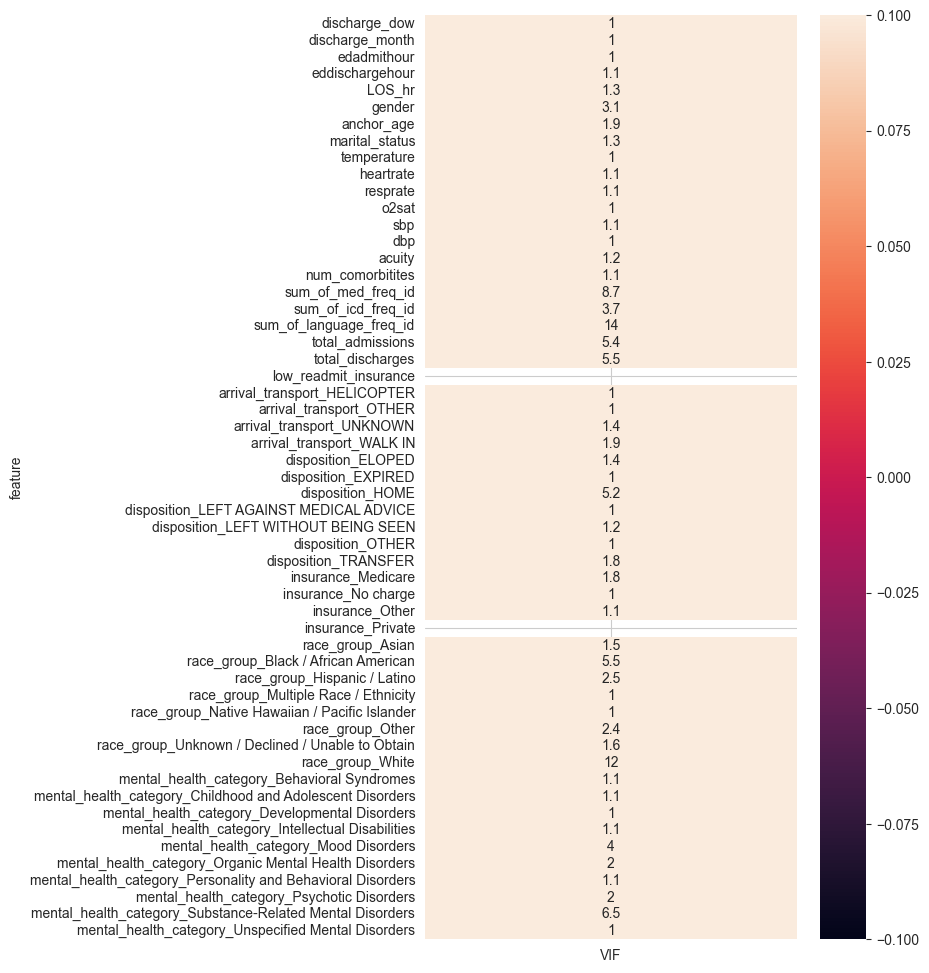

In [37]:
# Plot Heat Map
fig,ax = plt.subplots(figsize=(6,12))
sns.heatmap(vif_df,annot=True)

It seems that most variables have a low VIF indicating there isn't much multicolinearity. To get a better look I will use a correlation matrix

<Axes: >

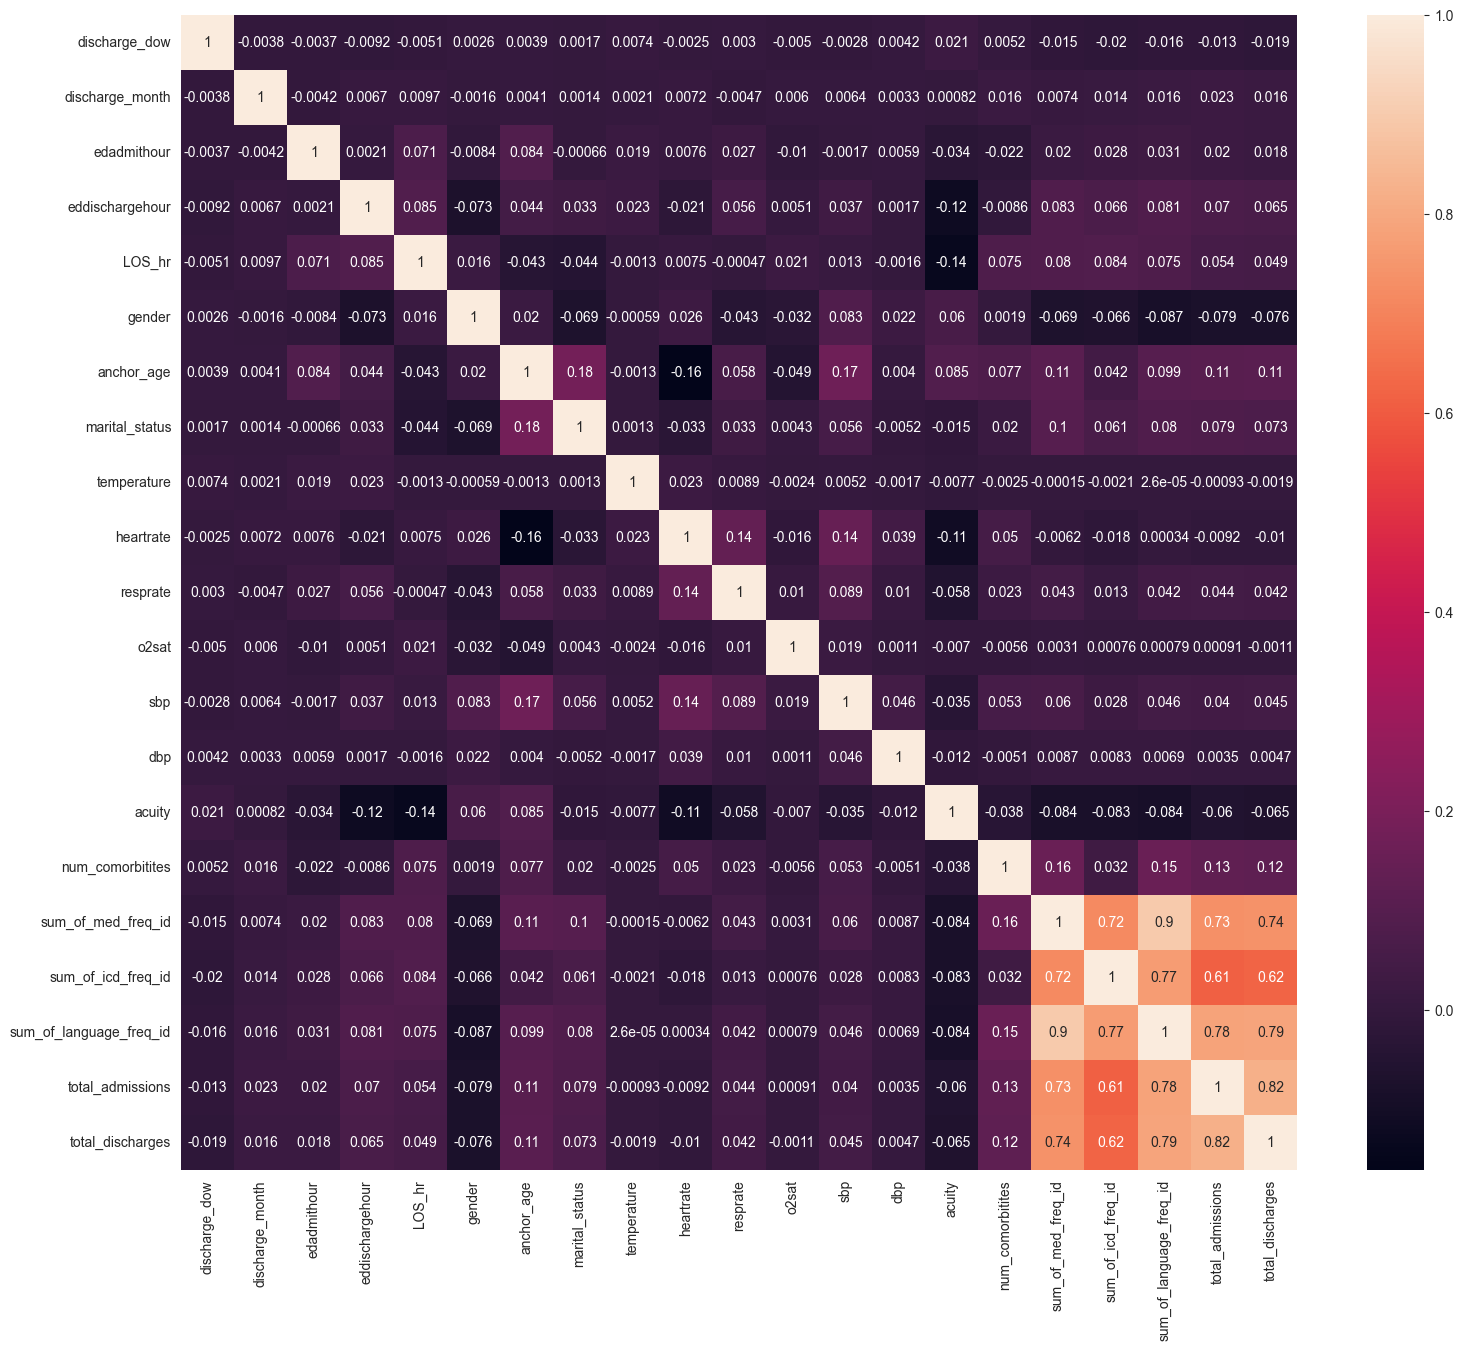

In [38]:
# Use a correlation matrix to identify which variables are correlated with one another
train_numeric_corr = train_df_cleaned.select_dtypes(include='float').drop(columns=['subject_id','hadm_id','readmit_stay_id'])
train_numeric_corr = train_numeric_corr.iloc[:,:21].corr()
# Plot heatmap
plt.figure(figsize=(18,15))
sns.heatmap(train_numeric_corr,annot=True)

So there are some obvious variables that are correlated with one another that I could combine or remove:
- Total admissions and total discharges are highly correlated. I could combine them to create a total admission to discharge ratio variable
- There are some other variables that are highly correlated like language, language, and med freq ids but these all represent different concepts. I will keep them as is for now. Tree based models are not impacted really by multicollinearity. I can drop one of them later if need be. 

In [39]:
train_df_cleaned.drop(columns=['subject_id','hadm_id','readmit_stay_id']).corr()['is_readmission']


discharge_dow                                                 -0.008901
discharge_month                                                0.007899
edadmithour                                                    0.016218
eddischargehour                                               -0.043069
LOS_hr                                                         0.001411
gender                                                         0.150388
anchor_age                                                     0.114510
marital_status                                                -0.085680
temperature                                                   -0.000854
heartrate                                                      0.017615
resprate                                                      -0.012432
o2sat                                                         -0.018467
sbp                                                           -0.028216
dbp                                                            0

### Handling Outliers

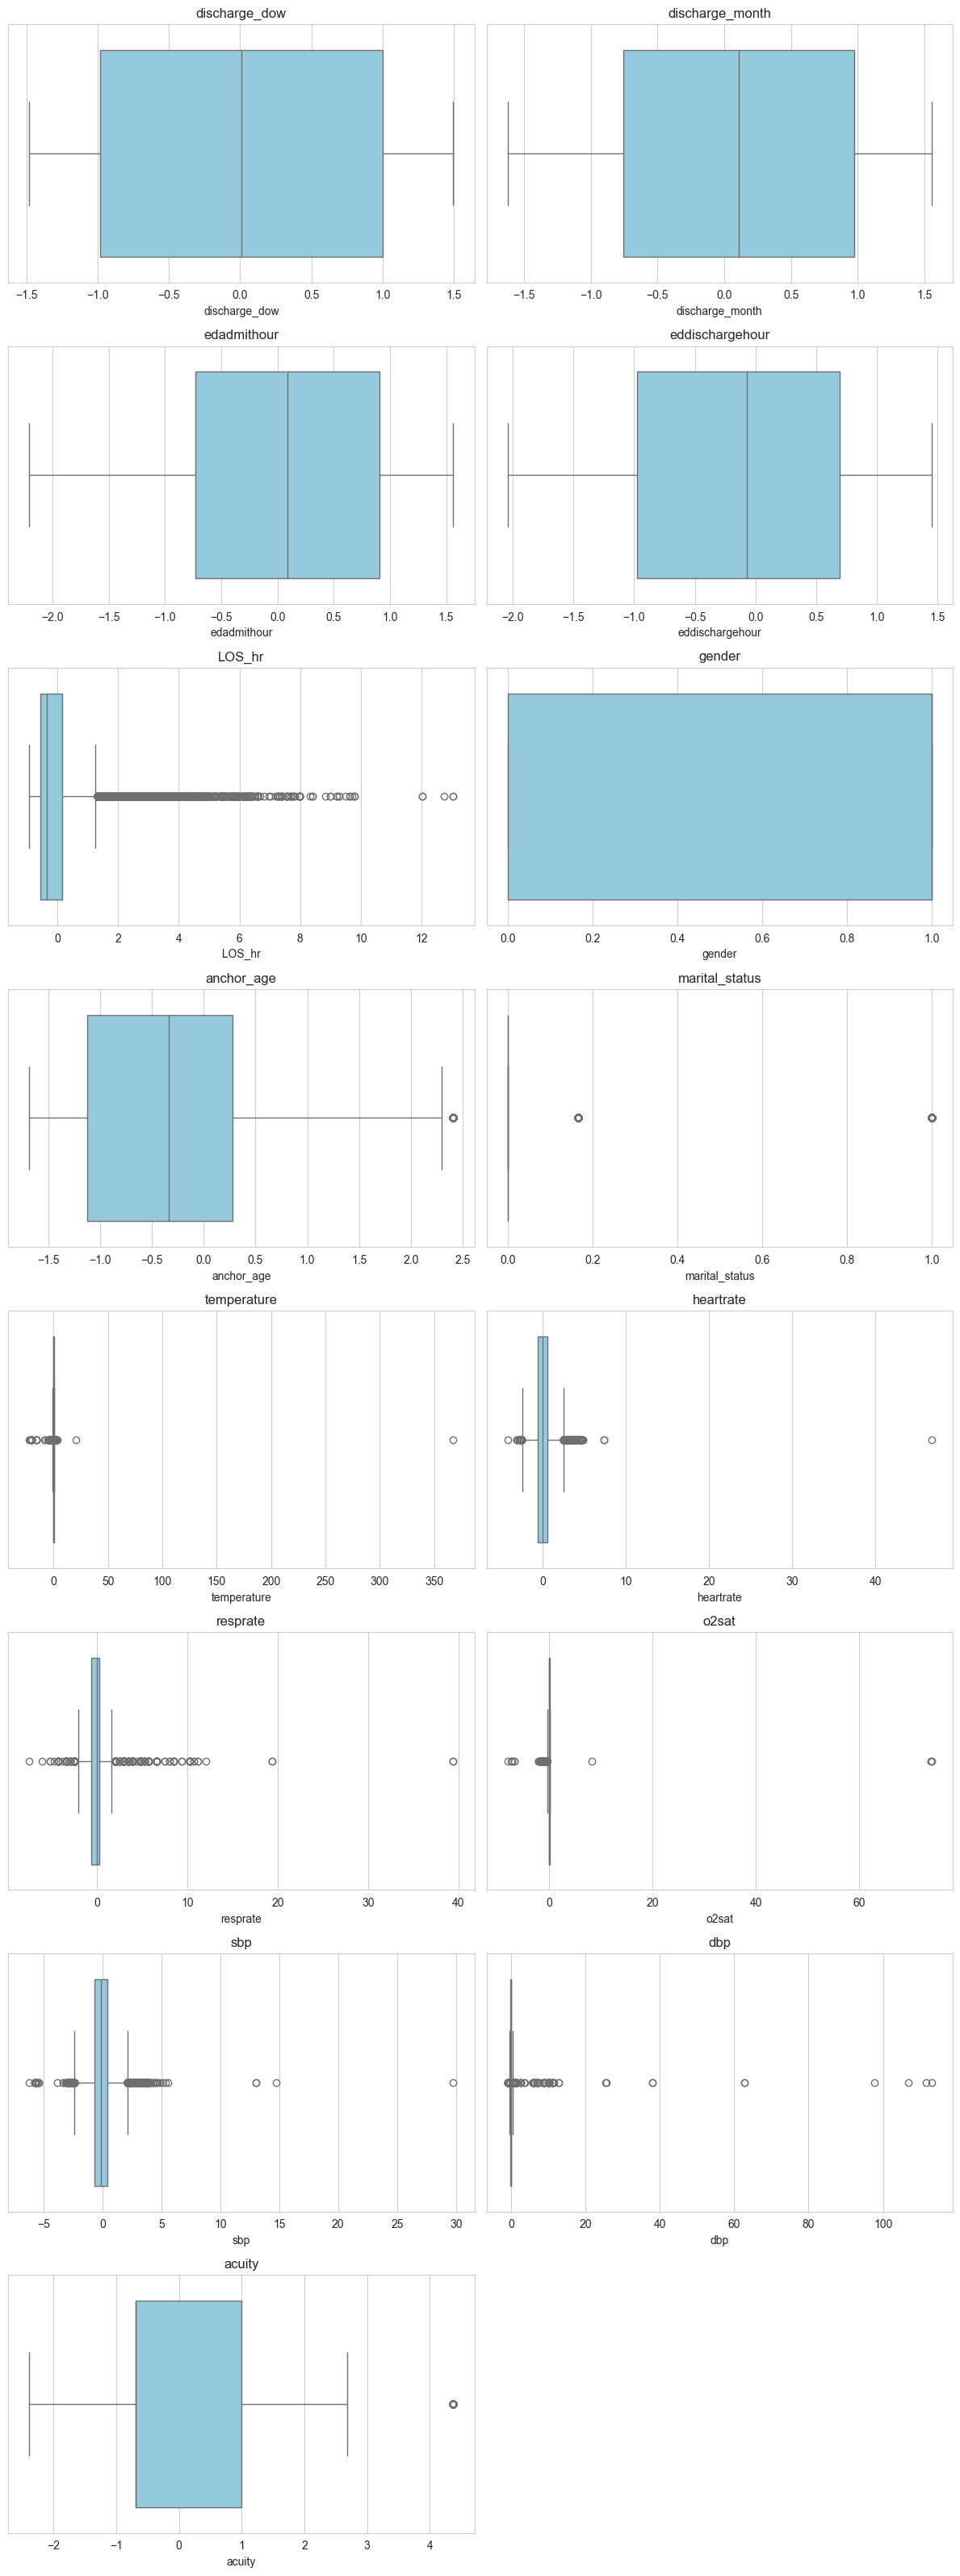

In [40]:
import math
# plot boxplots to identify which columns have outliers
# Select only numeric columns
numeric_columns = train_df_cleaned.select_dtypes(include='number').drop(columns=['subject_id','hadm_id','readmit_stay_id']).iloc[:,:15].columns

# Set up for 2 plots per row
cols = 2
rows = math.ceil(len(numeric_columns) / cols)

fig, axes = plt.subplots(rows, cols, figsize=(12, 4 * rows))
axes = axes.flatten()

for i, column in enumerate(numeric_columns):
    sns.boxplot(data=train_df_cleaned, x=column, ax=axes[i], color='skyblue')
    axes[i].set_title(f'{column}', fontsize=12)
    axes[i].set_xlabel(column)

# Turn off any unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

There are quite a few columns with outliers that I will have to deal with. While tree based models can handle outliers, I will simply impute them for my base models which are more simple and sensitive to outliers.

In [41]:
class OutlierImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.cols_ = None
        self.skip_columns = [
            'subject_id', 'stay_id', 'hadm_id', 'readmit_stay_id',
            'marital_status', 'gender',
            'sum_of_med_freq_id', 'sum_of_icd_freq_id', 'sum_of_language_freq_id',
            'low_readmit_insurance', 'admission_discharge_ratio'
        ]

    def fit(self, X, y=None):
        # Identify numeric columns to process
        numeric_cols = X.select_dtypes(include='number').columns
        self.cols_ = [col for col in numeric_cols 
                      if col not in self.skip_columns 
                      and col in X.columns][:14]
        return self

    def transform(self, X):
        df = X.copy()
        
        for col in self.cols_:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            LB = Q1 - 1.5 * IQR
            UB = Q3 + 1.5 * IQR

            outliers = (df[col] < LB) | (df[col] > UB)
            num_outliers = outliers.sum()
            median_val = df[col].median()
            df.loc[outliers, col] = median_val

            print(f"{col}: {num_outliers} outlier(s) imputed.")
        
        return df

### Class Imbalance

Certain Algorithmns can deal with class imbalances by over or under sampling certain classes. A certain hyperparameter such as class_weight must be adjusted. Alternatively, under or oversampling can be done using the pandas or numpy library

<Axes: xlabel='is_readmission'>

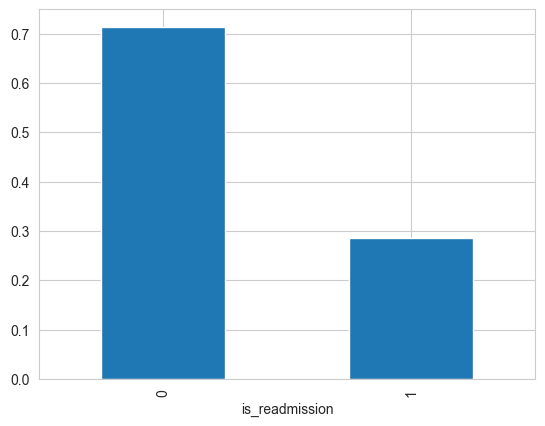

In [42]:
# Check for class imbalance
train_df_cleaned['is_readmission'].value_counts(normalize=True).plot(kind='bar')

There are significantly more cases of non readmission (0) compared to readmission. So, there is some class imbalance that I could potentially address to improve my models predictions. 

# Transform Additional Variables

In [98]:
# #'temperature',
#        'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'acuity',
#        'num_comorbitites', 'sum_of_med_freq_id', 'sum_of_icd_freq_id',
#        'sum_of_language_freq_id', 'admission_discharge_ratio',

def ConvertLOSHr(x,mean):
    """
    Convert LOS to a binary variable of 
    :return: Binary variables
    """
    if x > mean:
        return 1
    else:
        return 0
    
def SystolicAndDystolicBPConverter(SB, DB):
    """
    Classifies blood pressure based on systolic and diastolic values.

    :param SB: Systolic Blood Pressure (int or float)
    :param DB: Diastolic Blood Pressure (int or float)
    :return: String category (e.g., 'Normal', 'Elevated', 'Stage 1 Hypertension', etc.)
    """
    if SB < 120 and DB < 80:
        return "Normal"
    elif 120 <= SB <= 129 and DB < 80:
        return "Elevated"
    elif (130 <= SB <= 139) or (80 <= DB <= 89):
        return "Stage 1 Hypertension"
    elif (140 <= SB <= 180) or (90 <= DB <= 120):
        return "Stage 2 Hypertension"
    elif SB > 180 or DB > 120:
        return "Hypertensive Crisis"
    else:
        return "Uncategorized"

def O2SatConverter(X):
    """
    :param X: o2sat level
    :return: binary variable
    """
    
    if X < 95:
        return 1
    else:
        return 0
    



    

### Update the Preprocessing Pipeline

In [106]:
# Add a transformer to modify total admissions and total discharges to one variable
class GetTotalAdmissionsAndDischarges(BaseEstimator, TransformerMixin):
    """
    Calculates total admissions and discharges per admission day and discharge day, respectively
    """
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self  

    def transform(self, X):
        X_copy = X.copy().reset_index()
        
        # calculate the total admissions and total discharges 
        total_admissions = X_copy.groupby(by='edadmitdate')['stay_id'].count().reset_index().rename(columns={'stay_id':'total_admissions'})
        total_discharges = X_copy.groupby(by='eddischargedate')['stay_id'].count().reset_index().rename(columns={'stay_id':'total_discharges'})
        
        # merge these with original dataframe
        X_copy = X_copy.merge(total_admissions,how='left',on=['edadmitdate'])
        X_copy = X_copy.merge(total_discharges,how='left',on=['eddischargedate'])
        X_copy.drop(['edadmitdate','eddischargedate'],axis=1,inplace=True)
        
        # Create a ratio variable
        X_copy['admission_discharge_ratio'] = np.divide(X_copy['total_admissions'] , X_copy['total_discharges'] + 1e-5)
        X_copy.drop(['total_admissions','total_discharges'],axis=1,inplace=True)
        
        X_copy.set_index('stay_id', inplace=True)
        return X_copy

# Build Preprocessing Pipeline for later preprocessing of new data
X_train_preprocessing_Pipeline = Pipeline(
    [
        ('ConvertVitalSigns',ConvertVitalSignsToFloats()), # Converts vital signs to floats
        ('CelsiusToFahrenheit',CelsiusToFahrenheit()), # Standardizes temperature, converting it to Fahrenheit
        ('GetMedicationFrequencies',GetMedicationFrequencies()),# Converts medications into frequencies
        ('GetDiagnosesFrequencies',GetDiagnosesFrequencies()), # Converts Diagnosis to frequencies
        ('GetLanguageFrequencies',GetLanguageFrequencies()), # Converts languages to frequencies
        ('GetTotalAdmissionsAndDischarges',GetTotalAdmissionsAndDischarges()), # Calcaultes the total number of admissions and discharges for a given day
        ('Scaler', StandardScalar_Custom()), # Scales data
        ('MapGender',GenderMapper()), # Maps gender to 1 or 0, 1: male, 0: female
        ('MaritalStatusMapper',MaritalStatusMapper()), # Maps maritalstats to 1 or 0, 1: ismarried, 0: not married
        ('GetDisposition',GetDisposition()), # Maps disposition to 1 or 0. 1: LWBS, 0: Got treatment
        ('MapInsurance',InsuranceMapper()),# Maps insurance to 1 or 0. 1: low readmission, 0: high readmission
        ('OnehotEncoder',CreateDummies()),
        ('SimpleImputer', NumericImputer(strategy='median')),  # Fill the nulls with the median value for applicable features
    ]
)

# Build X Preprocessing Pipeline to impute outliers
X_train_preprocessing_pipeline_no_out = Pipeline(
    [
        ('ConvertVitalSigns',ConvertVitalSignsToFloats()), # Converts vital signs to floats
        ('CelsiusToFahrenheit',CelsiusToFahrenheit()), # Standardizes temperature, converting it to Fahrenheit
        ('GetMedicationFrequencies',GetMedicationFrequencies()),# Converts medications into frequencies
        ('GetDiagnosesFrequencies',GetDiagnosesFrequencies()), # Converts Diagnosis to frequencies
        ('GetLanguageFrequencies',GetLanguageFrequencies()), # Converts languages to frequencies
        ('GetTotalAdmissionsAndDischarges',GetTotalAdmissionsAndDischarges()), # Calcaultes the total number of admissions and discharges for a given day
        ('Scaler', StandardScalar_Custom()), # Scales data
        ('MapGender',GenderMapper()), # Maps gender to 1 or 0, 1: male, 0: female
        ('MaritalStatusMapper',MaritalStatusMapper()), # Maps maritalstats to 1 or 0, 1: ismarried, 0: not married
        ('GetDisposition',GetDisposition()), # Maps disposition to 1 or 0. 1: LWBS, 0: Got treatment
        ('MapInsurance',InsuranceMapper()),# Maps insurance to 1 or 0. 1: low readmission, 0: high readmission
        ('OnehotEncoder',CreateDummies()),
        ('SimpleImputer', NumericImputer(strategy='median')),  # Fill the nulls with the median value for applicable features
        ('OutlierImputer',OutlierImputer())
    ]
)
train_df_cleaned['bp_category'] = train_df_cleaned.apply(lambda row: SystolicAndDystolicBPConverter(row['sbp'], row['dbp']),axis=1)
train_df_cleaned['AboveAvgLOS'] = train_df_cleaned['LOS_hr'].apply(lambda x: ConvertLOSHr(x,train_df_cleaned['LOS_hr'].mean()))
train_df_cleaned['nonNormalo2sat'] = train_df_cleaned['o2sat'].apply(lambda x: O2SatConverter(x))

train_df_cleaned = X_train_preprocessing_Pipeline.fit_transform(train_df.drop(['is_readmission'],axis=1))
train_df_cleaned = train_df_cleaned.merge(train_df[['is_readmission']],left_index=True,right_index=True,how='left')
train_df_cleaned.drop_duplicates(inplace=True)


train_df_cleaned_no_out = X_train_preprocessing_pipeline_no_out.fit_transform(train_df.drop(['is_readmission'],axis=1))
train_df_cleaned_no_out = train_df_cleaned_no_out.merge(train_df[['is_readmission']],left_index=True,right_index=True,how='left')
train_df_cleaned_no_out.drop_duplicates(inplace=True)

discharge_dow: 0 outlier(s) imputed.
discharge_month: 0 outlier(s) imputed.
edadmithour: 0 outlier(s) imputed.
eddischargehour: 0 outlier(s) imputed.
LOS_hr: 12384 outlier(s) imputed.
anchor_age: 0 outlier(s) imputed.
temperature: 7210 outlier(s) imputed.
heartrate: 1590 outlier(s) imputed.
resprate: 9702 outlier(s) imputed.
o2sat: 2003 outlier(s) imputed.
sbp: 3978 outlier(s) imputed.
dbp: 3565 outlier(s) imputed.
acuity: 306 outlier(s) imputed.
num_comorbitites: 2279 outlier(s) imputed.


### Preprocess the Train and Test Set

In [44]:
# Use the X Train preprocessing Pipeline to transform the test data
test_df.set_index('stay_id',inplace=True)
test_df_cleaned = X_train_preprocessing_Pipeline.transform(test_df.drop(['is_readmission'], axis=1))
test_df_cleaned = test_df_cleaned.merge(test_df[['is_readmission']], left_index=True, right_index=True, how='left')
test_df_cleaned.drop_duplicates(inplace=True)

In [108]:
# Get the shapes of the train and test dfs
print('Train Shape:',train_df_cleaned.shape)
print('Test Shape:',test_df_cleaned.shape)

Train Shape: (51054, 61)
Test Shape: (30364, 58)


### Create Train, Validation, Test Splits

In [109]:
# Create the X_train, y_train variables
X_train = train_df_cleaned.drop(['subject_id','hadm_id','readmit_stay_id','is_readmission'],axis=1)
y_train = train_df_cleaned['is_readmission']

# Create a validation set
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.20,random_state=42,stratify=y_train) # use stratify to ensure both sets have the same class distribution as the original set

# Create the X_train_removed_outliers, y_train_removed_outliers variables
X_train_no_out = train_df_cleaned_no_out.drop(['subject_id','hadm_id','readmit_stay_id','is_readmission'],axis=1)
y_train_no_out = train_df_cleaned_no_out['is_readmission']

# Create a validation set no outliers
X_train_no_out,X_val_no_out,y_train_no_out,y_val_no_out = train_test_split(X_train_no_out,y_train_no_out,test_size=0.20,random_state=42)

# Create the X_test, y_test variables
X_test = test_df_cleaned.drop(['subject_id','hadm_id','readmit_stay_id','is_readmission'],axis=1)
y_test = test_df_cleaned['is_readmission']



print('X_train Shape:',X_train.shape)
print('y_train Shape:',y_train.shape)
print('X_train_no_out Shape:',X_train_no_out.shape)
print('y_train_no_out Shape:',y_train_no_out.shape)
print('X_val Shape:',X_val.shape)
print('y_val Shape:',y_val.shape)
print('X_test Shape:',X_test.shape)
print('y_test Shape:',y_test.shape)

X_train Shape: (40843, 57)
y_train Shape: (40843,)
X_train_no_out Shape: (40843, 54)
y_train_no_out Shape: (40843,)
X_val Shape: (10211, 57)
y_val Shape: (10211,)
X_test Shape: (30364, 54)
y_test Shape: (30364,)


### Model Building

In [61]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.naive_bayes import BernoulliNB,MultinomialNB
from sklearn.linear_model import LogisticRegression

#### Naive Bayes Model

In [47]:
X_train.columns

Index(['discharge_dow', 'discharge_month', 'edadmithour', 'eddischargehour',
       'LOS_hr', 'gender', 'anchor_age', 'marital_status', 'temperature',
       'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'acuity',
       'num_comorbitites', 'sum_of_med_freq_id', 'sum_of_icd_freq_id',
       'sum_of_language_freq_id', 'admission_discharge_ratio',
       'low_readmit_insurance', 'arrival_transport_HELICOPTER',
       'arrival_transport_OTHER', 'arrival_transport_UNKNOWN',
       'arrival_transport_WALK IN', 'disposition_ELOPED',
       'disposition_EXPIRED', 'disposition_HOME',
       'disposition_LEFT AGAINST MEDICAL ADVICE',
       'disposition_LEFT WITHOUT BEING SEEN', 'disposition_OTHER',
       'disposition_TRANSFER', 'insurance_Medicare', 'insurance_No charge',
       'insurance_Other', 'insurance_Private', 'race_group_Asian',
       'race_group_Black / African American', 'race_group_Hispanic / Latino',
       'race_group_Multiple Race / Ethnicity',
       'race_group_Native Hawa

In [110]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score


nb_cols = ['discharge_dow', 'discharge_month', 'edadmithour', 'eddischargehour',
       'LOS_hr','anchor_age','temperature',
       'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'acuity',
       'num_comorbitites', 'sum_of_med_freq_id', 'sum_of_icd_freq_id',
       'sum_of_language_freq_id', 'admission_discharge_ratio']

X_train_NB = X_train.drop(nb_cols,axis=1)
X_val_NB = X_val.drop(nb_cols,axis=1)


naive_bayes = BernoulliNB()
naive_bayes.fit(X_train_NB,y_train)

ValueError: could not convert string to float: 'Normal'

In [56]:
nb_y_pred_train = naive_bayes.predict(X_train_NB)
nb_y_pred_val = naive_bayes.predict(X_val_NB)

print("Best Model F1 score on train set: ",f1_score(y_train,nb_y_pred_train))
print("Best Model F1 score on validation set: ",f1_score(y_val,nb_y_pred_val))

Best Model F1 score on train set:  0.40922596565442915
Best Model F1 score on validation set:  0.414014014014014


In [57]:
print(classification_report(y_val, nb_y_pred_val))

              precision    recall  f1-score   support

         0.0       0.77      0.86      0.81      7291
         1.0       0.50      0.35      0.41      2920

    accuracy                           0.71     10211
   macro avg       0.63      0.61      0.61     10211
weighted avg       0.69      0.71      0.70     10211


So according to the precision of the classification report I can only trust my models predictions on the positive class about 50% of the time. But of the those predicitions on the validation set, only about 35% of the positive class (readmissions) were predicted correctly. 

In [94]:
X_train_MB = train_df_cleaned.drop(['is_readmission'],axis=1)
y_train_MB = train_df_cleaned['is_readmission']

# Create a validation set
X_train_MB,X_val_MB,y_train_MB,y_val_MB = train_test_split(X_train_MB,y_train_MB,test_size=0.20,random_state=42,stratify=y_train_MB)
print('X Train NB Size:',X_train_MB.shape)
print('y Train NB Size:',y_train_MB.shape)

# Get the scaler step from the pipeline
scaler = X_train_preprocessing_pipeline_no_out.named_steps['Scaler']

# Reverse the scaling
mb_cols = ['num_comorbitites', 'sum_of_med_freq_id', 'sum_of_icd_freq_id','sum_of_language_freq_id']
X_train_MB = scaler.inverse_transform(X_train_MB)
X_train_MB = np.abs(X_train_NB[mb_cols])

X_val_MB = scaler.inverse_transform(X_val_MB)
X_val_MB = np.abs(X_val_NB[mb_cols])

mb_nb = MultinomialNB()
mb_nb.fit(X_train_MB,y_train_MB)



X Train NB Size: (40843, 57)
y Train NB Size: (40843,)


MultinomialNB()

In [95]:
mb_nb_y_pred_train = mb_nb.predict(X_train_MB)
mb_nb_y_pred_val = mb_nb.predict(X_val_MB)

print("Best Model F1 score on train set: ",f1_score(y_train_MB,mb_nb_y_pred_train))
print("Best Model F1 score on validation set: ",f1_score(y_val_MB,mb_nb_y_pred_val))

Best Model F1 score on train set:  0.3782730762619607
Best Model F1 score on validation set:  0.38287560581583197


In [96]:
print(classification_report(y_val_MB,mb_nb_y_pred_val))

              precision    recall  f1-score   support

         0.0       0.72      0.44      0.55      7291
         1.0       0.29      0.57      0.38      2920

    accuracy                           0.48     10211
   macro avg       0.50      0.50      0.46     10211
weighted avg       0.59      0.48      0.50     10211


Compared to the Bernoulli Naive Bayes model the Multinomial Naive Bayes model performs much worse when just fed the count data

#### Logistic Regression

In [ ]:


lr_param_grid = {
    'C': np.logspace(-3,3,5),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'max_iter': [100,500,1000],
    'class_weight':['balanced', None]
}

# Use Grid SearchCV to find the best parameters
lr_rs = GridSearchCV(LogisticRegression(), param_grid=lr_param_grid, cv=3, n_jobs=-1,scoring='f1') # use f1 score for model evaluation due to data imbalance
lr_rs.fit(X_train_no_out,y_train_no_out)

In [ ]:
lr_rs.best_params_

In [ ]:
# Check to verify if there is any overfitting or underfitting present in the data
y_pred_train = lr_rs.predict(X_train_no_out)
y_pred_val = lr_rs.predict(X_val_no_out)

# Use weighted f1 average due to the data being imbalanced
print("Best model F1 score on train set:", f1_score(y_train_no_out, y_pred_train, average='weighted'))
print("Best model F1 score on validation set:", f1_score(y_val_no_out, y_pred_val, average='weighted'))


There isn't really much overfitting or underfitting here that needs to be addressed here suggesting the model generalizes well.

In [ ]:
LR_random_search_y_pred_val = lr_rs.predict(X_val_no_out)
print(classification_report(y_val_no_out, LR_random_search_y_pred_val))

Setting class_weight='balanced' led to a higher weighted avg f1_score (67%) on the validation set, weighted avg is important here because the dataset is imbalanced. GridSearchCV identified class_weight='Balanced' as the optimal setting based on the scoring metric used, likely due to the f1 score taking into account the individual predcitions for both classes. The recall here for the positive class (readmissions) is significantly higher for recall compared to precision. So, this tells me that my models predictions on the positive class can't really be trusted but it corretly predicited readmissions more than half the time. 

In [ ]:
from sklearn.metrics import confusion_matrix

# Balanced Predicitions
train_conf_matrix_rnd = confusion_matrix(y_train_no_out, lr_rs.predict(X_train_no_out),normalize='all')
val_conf_matrix_rnd = confusion_matrix(y_val_no_out, lr_rs.predict(X_val_no_out),normalize='all')


# Create a confusion Matrix Heatmap of performance on the training and validation set
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2, figsize=(15,7))

# Heatmap: Training Data(Balanced)
sns.heatmap(train_conf_matrix_rnd,annot=True,ax=ax1)
ax1.set_title("Confusion Matrix: Training Data(Balanced)")

# Heatmap: Validation Data(Balanced)
sns.heatmap(val_conf_matrix_rnd,annot=True,ax=ax2)
ax2.set_title("Confusion Matrix: Validation Data(Balanced)")

#### Support Vector Machine

In [ ]:
# SVM can take long to train on nonlinear data, so I will use only a sample of the training data and then use the optomized parameters and fit them to the full training data

# Sample only 10%
X_sample, _, y_sample, _ = train_test_split(
    X_train_no_out, y_train_no_out, 
    train_size=0.1, stratify=y_train_no_out, random_state=42
)

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV

svc_param_grid = {
    'C': np.logspace(-3,3,3), # 3 options
    'gamma': np.logspace(-3,3,3), # 3 options
    'degree': [2,3,4], # 3 options
    'class_weight':['balanced',{0: 1, 1: 3}], # 2 options
    'shrinking':[False,True] # 2 options
} # 3 x 3 x 2 x 2 = 36 X 3 = 108 combinations

# Use Random SearchCV to find the best parameters
# Randomly select 5 combinations of the 108 and complete 15 rounds of training on sample data
svc_rand_search = RandomizedSearchCV(SVC(), param_distributions=svc_param_grid,n_iter=5, cv=4, n_jobs=-1,scoring='f1') # use f1 score for model evaluation due to data imbalance
svc_rand_search.fit(X_sample,y_sample)

In [ ]:
# Due to the model 

In [1]:
# Use the best parameters from the sample data and train and fit it to the full dataset
svc = SVC(C=1000,class_weight={0:1,1:3},degree=2,gamma=0.001,shrinking=False)
svc.fit(X_train_no_out,y_train_no_out)

NameError: name 'SVC' is not defined

In [ ]:
# Check to verify if there is any overfitting or underfitting present in the data
y_pred_train = svc_rand_search.predict(X_train_no_out)
y_pred_val = svc_rand_search.predict(X_val_no_out)

# Use weighted average due to the data being imbalanced
print("Best model F1 score on train set:", f1_score(y_train_no_out, y_pred_train, average='weighted'))
print("Best model F1 score on validation set:", f1_score(y_val_no_out, y_pred_val, average='weighted'))

### Feature Selection with Random Forest Model

Using the Random Forest Model or any other tree based model can be very effective for quickly seeing what features are important in your model. So, I will use a random forest here to do that.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV


In [ ]:

# The Random Forest Classifier is an ensemble model that trains on random samples of the training data provided (bootstrapping). It takes the classification from each of the models trained on a random sample of the data
# and selects the classification based on the majority of the models.The randomness of samples helps to reduce overfitting compared to if a single decision tree was used.


# Build a Random Forest Model

rnd_clf_params = {
    'n_estimators': [100, 200, 500,1000], # how many decision trees to train
    'max_leaf_nodes': [8,10, 16, 20], # when a tree should reach its final decision point,smaller values less risk of overfitting
    'max_depth': [None, 8, 10, 20], # limits the depth of each decision tree, smaller values less risk of overfitting
    'class_weight':['balanced','balanced_subsample',None] # addresses class imbalance
}

# Use Random SearchCV to find the best parameters
rnd_rand_search = RandomizedSearchCV(RandomForestClassifier(), param_distributions=rnd_clf_params, cv=5, n_iter=10, n_jobs=-1, random_state=42,scoring='f1') 
rnd_rand_search.fit(X_train,y_train)


In [ ]:
# See how well the model fits the data by scoring it on the training data
y_pred_train = rnd_rand_search.predict(X_train)
y_pred_val = rnd_rand_search.predict(X_val)

# Use weighted average due to the data being imbalanced
print("F1 score: Best model score on train set:", f1_score(y_train, y_pred_train, average='weighted'))
print("F1 score: Best model validation on train set:", f1_score(y_val, y_pred_val, average='weighted'))


In [ ]:
y_pred = rnd_rand_search.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
# Get Feature Importances
rnd_clf_optomized = RandomForestClassifier(n_estimators=1000, max_leaf_nodes=20,n_jobs=-1,random_state=42,class_weight='balanced')
rnd_clf_optomized.fit(X_train,y_train)

In [ ]:
importances = rnd_clf_optomized.feature_importances_
feat_imporances = pd.DataFrame({'features': X_train.columns, 'importance': importances}).sort_values(by='importance',ascending=False)
feat_imporances['cumulative_importance'] = feat_imporances['importance'].cumsum()

In [ ]:
feat_imporances

In [ ]:
# Selecting the features with less than 95% of importance means those features make 95% of importnace
important_features = feat_imporances[feat_imporances['cumulative_importance'] <= 0.95]['features'].tolist()


In [ ]:
# Only retain the features that were most important in the models prediciton
X_train = X_train[important_features].copy()
X_val = X_val[important_features].copy()
X_test = X_test[important_features].copy()
X_train_no_out = X_train_no_out[important_features].copy()
X_val_no_out = X_val_no_out[important_features].copy()

In [ ]:
rnd_clf_optomized = RandomForestClassifier(n_estimators=1000, max_leaf_nodes=20,n_jobs=-1,random_state=42,class_weight='balanced')
rnd_clf_optomized.fit(X_train,y_train)


In [ ]:
# See how well the model fits the data by scoring it on the training data
y_pred_train = rnd_clf_optomized.predict(X_train)
y_pred_val = rnd_clf_optomized.predict(X_val)

# Use weighted average due to the data being imbalanced
print("F1 score: Best model score on train set:", f1_score(y_train, y_pred_train, average='weighted'))
print("F1 score: Best model validation on train set:", f1_score(y_val, y_pred_val, average='weighted'))

In [ ]:
y_pred = rnd_clf_optomized.predict(X_test)
print(classification_report(y_test, y_pred))

After applying RandomizedSearchCV with the scoring metric set to 'f1', the model better accounted for the class imbalance in the data. It identified that setting class_weight='balanced' led to more fair predictions across both the majority and minority classes. While this adjustment slightly reduced overall accuracy, it significantly improved the model’s ability to detect the minority class, which is especially important in a healthcare context where predicting readmissions is the priority.

In addition, leveraging feature importances to retain only the most predictive features further enhanced model performance. This combination of class balancing and feature selection boosted accuracy from the 50s to nearly 70%, marking a substantial improvement over the initial logistic regression baseline.

## Voting Classifier

Voting classifiers is a learning method in which a diverse set of machine learning models are combined to produce better predictions based on the majority votes. Much like students voting on a class president.

In [ ]:
from sklearn.ensemble import VotingClassifier
clf_lr = LogisticRegression()
clf_rnd = RandomForestClassifier()

# Voting Classifier
vt_clf = VotingClassifier(estimators=[
    ('lr',clf_lr),
    ('rf',clf_rnd)
],weights=[1,3],voting='soft') 

# parameter grid for randomsearch
param_grid = {
    'voting':['soft', 'hard'], # hard voting: majority wins, soft voting: averages predicted probabilities and picks the class with the highest mean probability
    'lr__C': np.logspace(-3,3,5),
    'lr__penalty': ['l1', 'l2'],
    'lr__solver': ['liblinear'],
    'lr__max_iter': [100,500,1000],
    'lr__class_weight':['balanced', None],
    'rf__n_estimators': [100, 200, 500,1000], 
    'rf__max_leaf_nodes': [8,10, 16, 20], 
    'rf__max_depth': [None, 8, 10, 20],
    'rf__class_weight':['balanced','balanced_subsample',None]
}
voting_random_clf = RandomizedSearchCV(vt_clf,cv=3,param_distributions=param_grid,scoring='f1',random_state=42,n_jobs=-1,verbose=1)
voting_random_clf.fit(X_train,y_train)

In [ ]:
y_pred_train = voting_random_clf.predict(X_train)
y_pred_val = voting_random_clf.predict(X_val)

print("F1 Score: Best model score on train set:", f1_score(y_train, y_pred_train, average='weighted'))
print("F1 Score: Best model validation on train set:", f1_score(y_val, y_pred_val, average='weighted'))

In [ ]:
y_pred = voting_random_clf.predict(X_test)
print(classification_report(y_test, y_pred))

# Testing Different Models

The Accuracy for the model seems to be relatively decent, however, I will try to see how the model performs on other tree based models. To see if I can get better performance. 

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

param_grid = {
    'n_estimators': [400, 500,600],
    'learning_rate': [0.01, 0.05, 0.1,1],
    'max_depth': [2, 3, 4],
    'subsample':[0.25,0.10,0.15]
}

gbrt_rnd_search = RandomizedSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1
)
gbrt_rnd_search.fit(X_train,y_train)

In [ ]:
print("Best F1 score:", gbrt_rnd_search.best_score_)

In [ ]:
gbrt_rnd_search.score(X_train,y_train)

In [ ]:
gbrt_rnd_search.score(X_val,y_val)

In [ ]:
gbrt_rnd_search.score(X_test,y_test)

In [ ]:
y_pred = gbrt_rnd_search.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
train_conf_matrix_gbrt = confusion_matrix(y_train, random_search.predict(X_train),normalize='all')
val_conf_matrix_gbrt = confusion_matrix(y_val, random_search.predict(X_val),normalize='all')


# Create a confusion Matrix Heatmap of performance on the training and validation set
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(8,4))

# Heatmap: Training Set
sns.heatmap(train_conf_matrix_gbrt,annot=True,ax=ax1)
ax1.set_title("Confusion Matrix: Training Data")

# Heatmap: Validation Set
sns.heatmap(val_conf_matrix_gbrt,annot=True,ax=ax2)
ax2.set_title("Confusion Matrix: Validation Data")

In [ ]:
import xgboost as xgb
# Use "hist" for constructing the trees, with early stopping enabled.
clf = xgb.XGBClassifier(tree_method="hist", early_stopping_rounds=2)
# Fit the model, test sets are used for early stopping.
clf.fit(X_train.values, y_train.values, eval_set=[(X_val.values, y_val.values)])


In [2]:
clf.score(X_train.values, y_train.values)

NameError: name 'clf' is not defined

In [3]:
clf.score(X_val.values, y_val.values)

NameError: name 'clf' is not defined

In [4]:
clf.score(X_test.values, y_test.values)

NameError: name 'clf' is not defined

# Build Model Pipeline